In [1]:
import csv
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import hashlib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from pandas.plotting import scatter_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#Loading the data for the dataset into a pandas dataframe
data_df = pd.read_csv("https://raw.githubusercontent.com/alexhegit/handson-ml2/master/datasets/housing/housing.csv")

In [3]:
#Displaying the contents of the data
data_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
#Viewing the information about the columns of the dataframe
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#Computing the number of distinct categories in data_df.ocean_proximity column
data_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
#Viewing the summary of numerical attributes of the data
data_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a54ecde50>,
      dtype=object)

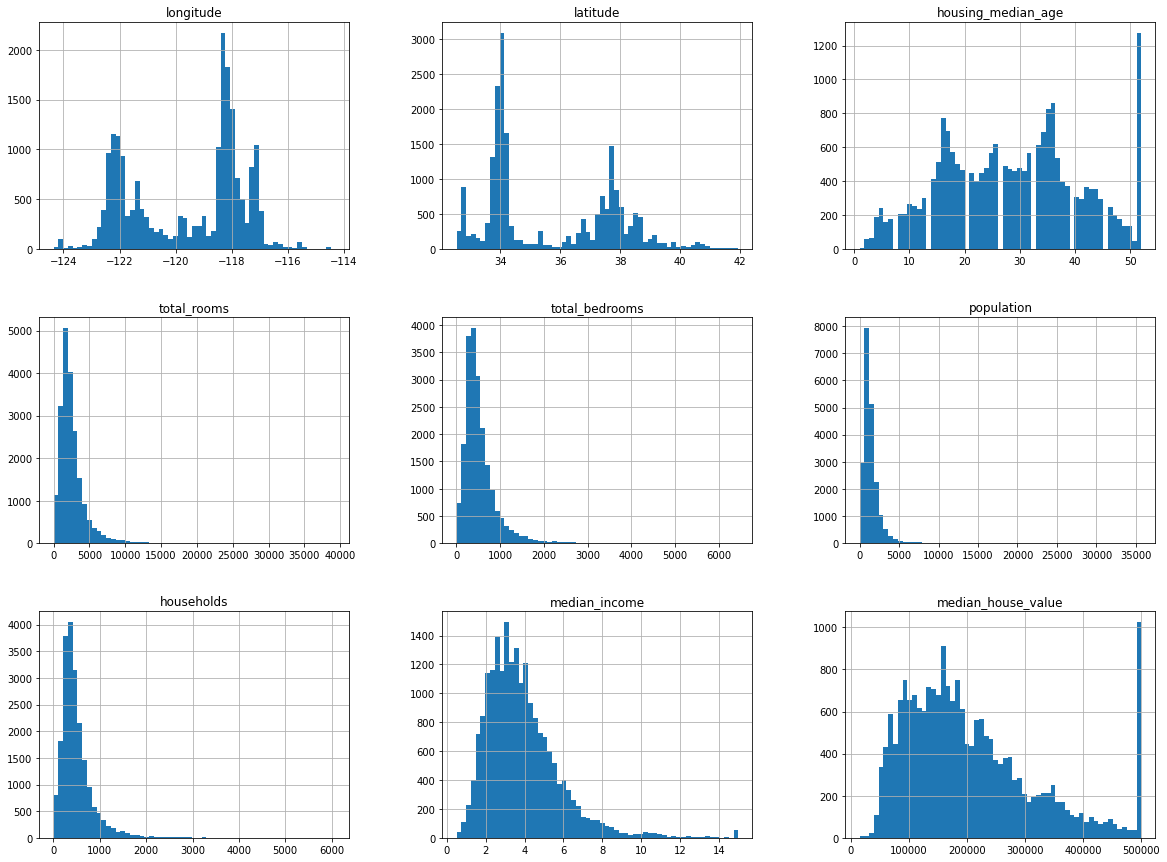

In [7]:
#Drawing the histogram for the columns of the given data
data_df.hist(bins=59, figsize=(20,15))

# Splitting Dataset into Testing and Training Datasets

In [8]:
'''
#Creating method to split the total data into training and testing data
def split_train_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data)) #Shuffle the provided data
  test_set_size = int(len(data) * test_ratio) #Compute the length of testing data
  test_indices = shuffled_indices[:test_set_size] #Seperate a sample for testing data from the shuffled data
  train_indices = shuffled_indices[test_set_size:] #Seperate the rest of the data as training data from the shuffled data
  return data.iloc[train_indices], data.iloc[test_indices] #Return both types of datas when method is invoked

#Invoking the split_train_data() method to get training and testing data from the given dataset
train_set, test_set = split_train_data(data_df, 0.2) #Using a ratio of 0.2 i.e. 20% testing and 80% training data
print(len(train_set), "train + ", len(test_set), "test")
'''
print()

In [9]:
'''
#Updating the method for splitting total data so that testing data never concides with training data
def test_set_check(identifier, test_ratio, hash):
  return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio #Returns a hash value for test item if less then 20% of total data

def split_test_train_by_id(data, test_ratio, id_column, hash=hashli.md5):
  ids = data[id_column] #Specify the column which will be used as a hash value encoder
  in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio, hash)) #Computing the hash values on values of that column
  return data.loc[-in_test_set], data[in_test_set] #Splitting data into training and testing data based on hash values

#Applying the split_test_train_by_id() method to get training and testing data from the given dataset
id_df = data_df.reset_index()
train_set, test_set = split_test_train_by_id(id_df, 0.2, "index") #Using values of index for splitting 
'''
print()

In [10]:
#Splitting given dataset into test and training data
train_set, test_set = train_test_split(data_df, test_size=0.2, random_state=42) 

In [11]:
#Creating an income category from the given median income
data_df['income_category'] = np.ceil(data_df.median_income / 1.5)
data_df.income_category.where(data_df.income_category < 5, 5.0, inplace=True) #Merge all categories with income greater than 5 to income = 5 

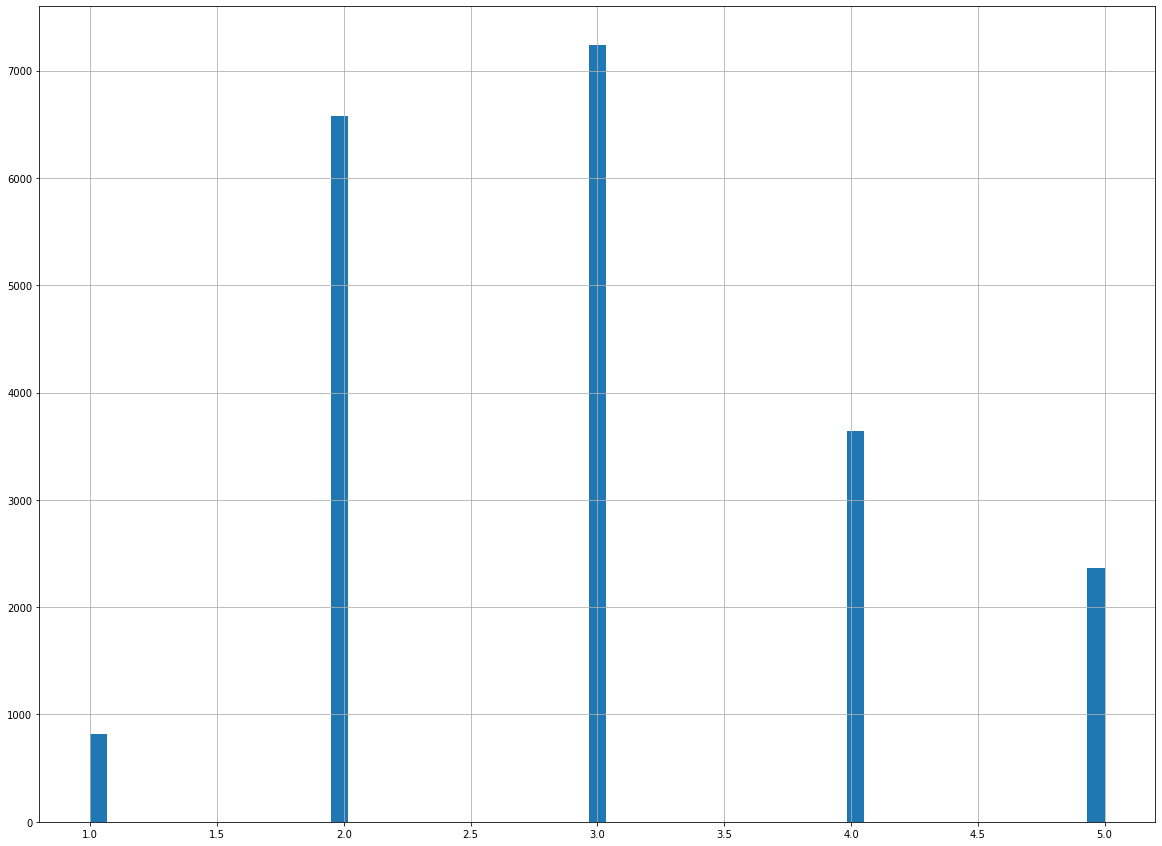

In [12]:
#Creating histogram of the newly created income category
data_df.income_category.hist(bins=59, figsize=(20,15))

In [13]:
#Applying stratified sampling on the income category data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #Creating a stratified splitter for 20% of test data
for train_index, test_index in split.split(data_df, data_df.income_category): #Computing stratified samples for training and testing data seperately
    strat_train_set = data_df.loc[train_index] #Creating the stratified training set
    strat_test_set = data_df.loc[test_index] #Creating the stratified testing set

#Computing income category proportions for the dataset after stratified sampling
data_df.income_category.value_counts() / len(data_df) 

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_category, dtype: float64

In [14]:
#Removing the income category attribute (we have successfully computed a successful test dataset)
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

# Exploring the Dataset

In [15]:
data_df = strat_train_set.copy() #Creating copy of stratified training set so we can explore data carefreely

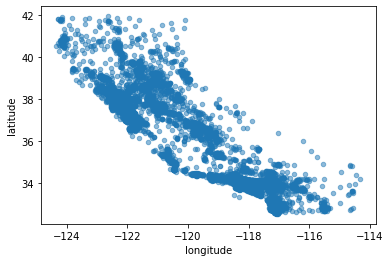

In [16]:
#Visualizing the geographical data in the dataset
data_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5) 

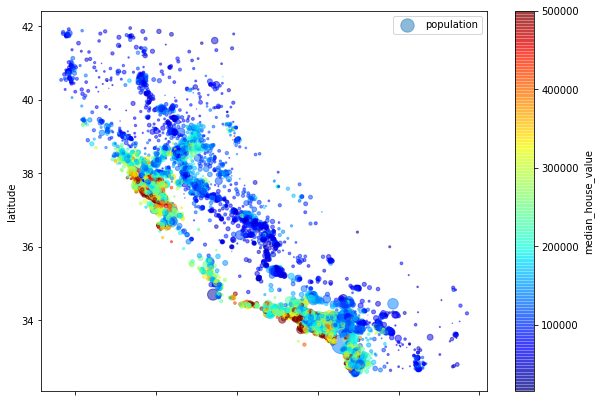

In [17]:
#Visualizing the geographical data in the dataset based on population and housing prices
data_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, s=data_df.population/100, label="population", 
             figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()

We can observe some things in the plot visualized i.e. the prices of houses are related to geographic location and to the population of that region. The houses near the ocean side have higher prices, although this doesn't count for the houses in the northern region.

In [18]:
corr_matrix = data_df.corr() #Computing the standard correlation coefficient (Pearson's r)
corr_matrix.median_house_value.sort_values(ascending=False) #Finding correlations between median house prices and other attributes

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a533096d0>,
      dtype=object)

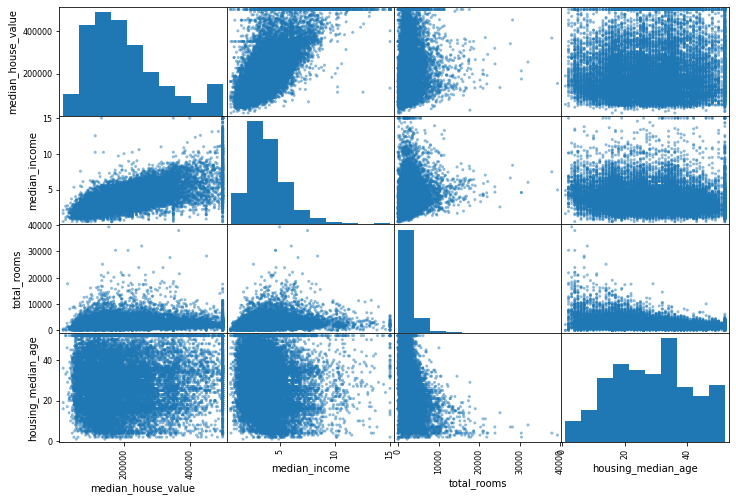

In [19]:
#Lets visualize the top 4 positive co-relations with median house values for the dataset
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(data_df[attributes], figsize=(12, 8))

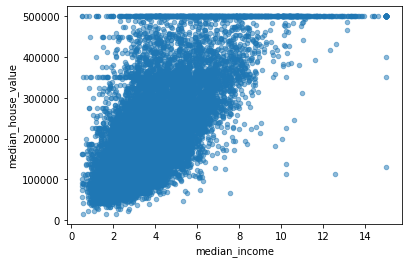

In [20]:
#Viewing the median_income plot vs median_house_value as it gives the highest correlation factor
data_df.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.5)

In [21]:
#Combining related data atrributes into a single attribute 
data_df['rooms_per_household'] = data_df.total_rooms / data_df.households
data_df['bedrooms_per_room'] = data_df.total_bedrooms / data_df.total_rooms
data_df['population_per_household'] = data_df.population / data_df.households

#Computing the correlation matrix for median house incomes once more
corr_matrix = data_df.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Transforming Data for Machine Learning Algorithm

In [22]:
#Cleaning data for the ML Algorithm
data_df = strat_train_set.drop("median_house_value", axis=1) #Collecting the predictors of the training dataset
data_labels = strat_train_set.median_house_value.copy() #Collecting the labels of the training dataset

#Filling the missing values in the various attributes of the given dataset
imputer = SimpleImputer(strategy="median") #Creating an imputer instance to fill missing values with median values
num_data_df = data_df.drop("ocean_proximity", axis=1) #Removing the textual attribute from the data (Median can only be computed on numbers)
imputer.fit(num_data_df) #Training the imputer instance on the numerical data
X = imputer.transform(num_data_df) #Applying the trained imputer instance on the numerical data
train_data_df = DataFrame(X, columns=num_data_df.columns) #Converts the arrays of transformed features into the dataframe

In [23]:
train_data_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [24]:
#Handling Text and Categorical Data Attributes

encoder = LabelEncoder() #Creating a Label Encoder instance
encoded_category = encoder.fit_transform(data_df.ocean_proximity) #Creating an encoder for the ocean_proximity attribute
encoded_category

array([0, 0, 4, ..., 1, 0, 3])

In [25]:
#Viewing the classes of the created encoder
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [26]:
#Discriminating encoder classes based on Ocean and Inland via One-Hot Encoding
encoder = OneHotEncoder() #Creating a OneHotEncoder instance
hot_encoded_category = encoder.fit_transform(encoded_category.reshape(-1,1)) #Reshaping encoded_category from 1D array to 2D array and creating a hot-encoder
hot_encoded_category

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [27]:
#One shot transform (Applying the Label Encoder and One-Hot Encoding in one go)
encoder = LabelBinarizer() #Creating a LabelBinarizer instance
hot_encoded_category = encoder.fit_transform(data_df.ocean_proximity)
hot_encoded_category #Returns a dense Numpy array instead of SciPy sparse matrix

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [28]:
#Creating custom transformations

#Creating a custom transformer class to combine different attributes of the data
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6 #Assigning the index numbers to attributes to be combined according to their order in dataset

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room=True): #Class with one hyperparameter (if we want to add bedrooms_per_room attribute or not)
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y = None): #Method to return the instance itself
        return self

    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix] #Compute the attribute rooms_per_household
        population_per_household = X[:, population_ix] / X[:, household_ix] #Compute the attribute population_per_household
        if self.add_bedrooms_per_room: #If hyperparameter is True, then compute the attribute bedrooms_per_room and return it with other attributes
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

#Applying the combined attribute class to create an attribute adder
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) #Hyperparameter turned off
extra_data_attributes = attr_adder.transform(data_df.values)

extra_data_attributes

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [29]:
#Creating a transformation pipeline for all the transformation applied so far
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), ('attribute_adder', CombinedAttributesAdder()), ('std_scalar', StandardScaler()), ])

#Applying all transformation of the pipeline on the data
train_data_df = num_pipeline.fit_transform(num_data_df)

In [30]:
#Creating a transformer class to extract the numerical columns for Imputer instance and categorical columns for LabelBinarizer instance
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.attribute_names].values

#Creating a New Label Binarizer transformation class which accepts only 2 arguments (For our case Label Binzarizer will not work as it needs 3 arguments)
class NewLabelBinarizer(LabelBinarizer):

    def fit(self, X, y=None):
        return super(NewLabelBinarizer, self).fit(X)

    def transform(self, X, y=None):
        return super(NewLabelBinarizer, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(NewLabelBinarizer, self).fit(X).transform(X)

#Applying this class for the given data
num_attributes = list(num_data_df) #Get the list of numerical attributes
cat_attributes = ["ocean_proximity"] #Get the list of categorical attributes

#Creating the numeric attributes pipeline
num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_attributes)),
                         ('imputer', SimpleImputer(strategy="median")),
                         ('attribs_addder', CombinedAttributesAdder()),
                         ('std_scalar', StandardScaler()),
                         ])

#Creating the categorical attributes pipeline
cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_attributes)),
                         ('label_binarizer', NewLabelBinarizer()),
                         ])

In [31]:
#Creating a full pipeline by combining the pipelines for numeric and categorical data
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline), ("cat_pipeline", cat_pipeline),])

#Applying the full pipeline on the given dataset to create data for training model
transformed_data = full_pipeline.fit_transform(data_df)
transformed_data

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [32]:
#Viewing the dimensions of the transformed data
transformed_data.shape

(16512, 16)

# Training a ML Model for the Dataset

In [33]:
#Creating a Linear Regression Model
linear_reg = LinearRegression()
linear_reg.fit(transformed_data, data_labels)

#Trying the linear regression model on the training data to find the RMSE(Root Mean Squared Error)
data_predictions = linear_reg.predict(transformed_data) #Computing predictions from the Regression model
linear_mse = mean_squared_error(data_labels, data_predictions) #Computing the MSE for Linear Regression model
linear_rmse = np.sqrt(linear_mse) #Computing the RMSE value from MSE
linear_rmse

68628.19819848923

The result of an error of \$68628 in price is not a good result as we already know that the range of median housing values is between \$120,000 and \$250,000. Thus a +- of 68628 can have a large impact. We say that our data is underfitted over Linear Regression Model.

In [34]:
#Creating a Decision Tree Regression Model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(transformed_data, data_labels)

#Trying the decision tree regression model on the training data to find the RMSE(Root Mean Squared Error)
data_predictions = tree_reg.predict(transformed_data) #Computing predictions from the Regression model
tree_mse = mean_squared_error(data_labels, data_predictions) #Computing the MSE for Decision Tree Regression model
tree_rmse = np.sqrt(tree_mse) #Computing the RMSE value from MSE
tree_rmse

0.0

The result of error being 0.0 means two things i.e. either the model is 100% accurate (which is least likely to happen) or the model has badly overfitted the data. The second case seems over appropriate. To make sure of things lets try something else to distinguish between the errors posed by these two models

In [35]:
#Using cross validation to evaluate the efficiency of the models

#Evaluating cross validation for Decision Tree Regressor
tree_scores = cross_val_score(tree_reg, transformed_data, data_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

#Evaluating cross validation for Linear Regressor
linear_scores = cross_val_score(linear_reg, transformed_data, data_labels, scoring="neg_mean_squared_error", cv=10)
linear_rmse_scores = np.sqrt(-linear_scores)

#Defining a function to view the scores, mean and standard deviation of the model
def display_scores(scores):
    print("Scores: {}".format(scores))
    print("Mean: {}".format(scores.mean()))
    print("Std. Deviation: {}".format(scores.std()))

In [36]:
#Viewing scores for the Linear Regression Model
display_scores(linear_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Std. Deviation: 2731.674001798344


In [37]:
#Viewing scores for the Decision Tree Regression Model
display_scores(tree_rmse_scores)

Scores: [68399.15331087 67169.78379816 71414.05611006 69626.72538607
 71109.60796747 75502.10711044 71090.06037321 71583.53774688
 75953.37205491 69433.0736332 ]
Mean: 71128.14774912685
Std. Deviation: 2663.6221445862775


In [38]:
#Creating a Random Forest Regression Model
forest_reg = RandomForestRegressor()
forest_reg.fit(transformed_data, data_labels) 

#Trying the random forest regression model on the training data to find the RMSE(Root Mean Squared Error)
data_predictions = forest_reg.predict(transformed_data) #Computing predictions from the Regression model
forest_mse = mean_squared_error(data_labels, data_predictions) #Computing the MSE for Random Forest Regression model
forest_rmse = np.sqrt(forest_mse) #Computing the RMSE value from MSE
forest_rmse

18596.999746716574

In [39]:
#Viewing the cross validation scores for Random Forest Regression Model
forest_scores = cross_val_score(forest_reg, transformed_data, data_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [49606.65002459 47872.34734982 49895.78457765 52313.0701649
 49680.56438863 53325.57529124 48472.43834488 48015.28485033
 52647.31457372 50338.34061874]
Mean: 50216.737018448744
Std. Deviation: 1847.4255839660575


# Fine Tuning the ML Model

In [44]:
#Applying Grid Search Cross Validation
param_grid = [
              {'n_estimators': [3,10,30], 'max_features':[2, 4, 6, 8]},
              {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
              ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(transformed_data, data_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [45]:
#Viewing the best parameters for fine tuning
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [46]:
#Viewing the best estimators for fine tuning
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [47]:
#Viewing the evaluation scores for fine tuning
grid_scores = grid_search.cv_results_
for mean_score, params in zip(grid_scores["mean_test_score"], grid_scores["params"]):
    print(np.sqrt(-mean_score), params)

63404.231030512405 {'max_features': 2, 'n_estimators': 3}
55652.65044454762 {'max_features': 2, 'n_estimators': 10}
52927.9731983076 {'max_features': 2, 'n_estimators': 30}
60864.42851573494 {'max_features': 4, 'n_estimators': 3}
53214.265954367555 {'max_features': 4, 'n_estimators': 10}
50398.03171016002 {'max_features': 4, 'n_estimators': 30}
58892.32613336693 {'max_features': 6, 'n_estimators': 3}
51847.87779997248 {'max_features': 6, 'n_estimators': 10}
49889.64965679767 {'max_features': 6, 'n_estimators': 30}
58366.073317612594 {'max_features': 8, 'n_estimators': 3}
52188.259150431826 {'max_features': 8, 'n_estimators': 10}
50134.95653303811 {'max_features': 8, 'n_estimators': 30}
61742.83218306426 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54235.268895190275 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59936.5627034041 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52888.58065949258 {'bootstrap': False, 'max_features': 3, 'n_estimators':

As it can be seen, our fine tuning improved the results of the Random Forest Regressor, as we get the value 49889 for our best parameters (max_features: 6, n_estimators: 30) from the original value 50216 we obtained from the Regressor without fine tuning

In [48]:
#Viewing the features of best estimator and analyzing their affects on performance
imp_features = grid_search.best_estimator_.feature_importances_
imp_features

array([7.60902569e-02, 7.24948220e-02, 4.45586551e-02, 1.92179586e-02,
       1.73706696e-02, 1.90734435e-02, 1.65906107e-02, 3.31533024e-01,
       5.99333749e-02, 1.06185508e-01, 7.48848006e-02, 1.21495608e-02,
       1.42740112e-01, 1.06205345e-04, 2.87987786e-03, 4.19111976e-03])

In [49]:
#Viewing scores for attributes for fine tuned model
extra_attributes = ['rooms_per_hhold', "pop_per_hhold", "bedrooms_per_room"]
one_hot_cat_attributes = list(encoder.classes_)
attributes = num_attributes + extra_attributes + one_hot_cat_attributes
sorted(zip(imp_features, attributes), reverse=True)

[(0.3315330244846272, 'median_income'),
 (0.1427401118072619, 'INLAND'),
 (0.1061855080533798, 'pop_per_hhold'),
 (0.0760902568949711, 'longitude'),
 (0.07488480059268549, 'bedrooms_per_room'),
 (0.07249482200256438, 'latitude'),
 (0.05993337490985134, 'rooms_per_hhold'),
 (0.044558655085701976, 'housing_median_age'),
 (0.01921795861508917, 'total_rooms'),
 (0.019073443534060944, 'population'),
 (0.017370669556818295, 'total_bedrooms'),
 (0.016590610746643107, 'households'),
 (0.012149560750273798, '<1H OCEAN'),
 (0.004191119760833555, 'NEAR OCEAN'),
 (0.0028798778605736717, 'NEAR BAY'),
 (0.00010620534466437869, 'ISLAND')]

In [50]:
#Evaluating Model on Test Dataset
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set.median_house_value.copy()

transformed_X_test = full_pipeline.transform(X_test) #Applying transformation pipeline on test dataset
final_predictions = final_model.predict(transformed_X_test) #Computing the predictions for the model on transformed test dataset

final_mse = mean_squared_error(Y_test, final_predictions) #Computing MSE value for the model
final_rmse = np.sqrt(final_mse) #Computing RMSE value from MSE value

In [51]:
#Viewing the RMSE value for model for the test set
final_rmse

47729.97431300321